### Campaign ROI Model

- Notebook Assumption 1: phone calls to leads are independent with respect to one another and we do not treat this as a time series problem
- Notebook Assumption 2: **the data scientist is working with the entire dataset of campaign phone calls, ranging from May 2008 to November 2010, and is performing the work after the campaign has ended e.g. December 2010**

- Task: create binary classification model to identify whether if a customer will subscribe to a term deposit offer- - - The model will be used by the campaign_ROI_prediction notebook

- A higher avg customer clv will allow for a proportionally lower decision threshold, and viceversa
- Duration cannot be used

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta
import pickle

In [2]:
import sklearn 
sklearn.__version__

'0.20.3'

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore', 'lbfgs failed to converge*')
warnings.filterwarnings('ignore', 'Data with input dtype int64*')
warnings.filterwarnings('ignore', 'The default value*')

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import RFECV

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, Binarizer, LabelBinarizer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

In [7]:
df = pd.read_pickle('data/data_ready.pickle')

In [8]:
df.drop(columns=['duration', 'day'], axis=1, inplace=True)

In [9]:
#One more check: no nulls so no need to use imputers in pipeline
#df.isnull().sum()

In [10]:
#not just of type numeric, but actual numeric on a scale - excludes binary and ordinal categorical attributes
#the below attributes will be scaled in the Pipeline
numeric_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
                   'cons.conf.idx', 'euribor3m', 'nr.employed', 'month_total_days']

In [11]:
binary_features = ['biz_payday', 'govt_payday', 'is_holiday']

In [12]:
#outcome is y,n,unknown
categorical_features = ['poutcome', 'job', 'marital', 'education', 'default', 'housing', 'loan', 
                       'month_last_contact', 'day_of_week_last_contact', 'holiday_name', 'weekday', 
                       'year', 'month']

In [13]:
label_binary = ['contact']

In [14]:
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

We are experiencing a strong class imbalance:



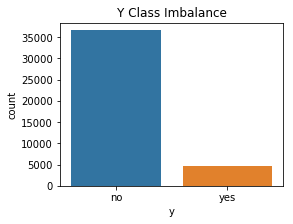

In [15]:
print("We are experiencing a strong class imbalance:\n")
fig, ax = plt.subplots(figsize=(4,3))
sns.countplot(x="y", data=df)
plt.title('Y Class Imbalance')
plt.show()

In [16]:
#df['y'] = [1 if i == 'yes' else 0 for i in df.y]

In [17]:
#passthrough = ['year', 'month', 'day']

In [18]:
#Models to be evaluated - can be modified/overridden to include more
def models():
    models = {}
    models['log'] = (LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=1), {'C':[0.01, 0.1, 1]})
    models['ridge'] = (RidgeClassifier(class_weight='balanced', random_state=1), {'alpha':[0.01, 0.1, 1]})
    #models['svc'] = (SVC(class_weight='balanced'), {'C':[0.1, 1], 'gamma':['auto']})
    models['ada'] = (AdaBoostClassifier(random_state=1), {'learning_rate':[0.5, 1]})
    models['gbm'] = (GradientBoostingClassifier(random_state=1), {'learning_rate':[0.5, 1]})
    #models['gaus_nb'] = (GaussianNB(), {'var_smoothing':[1e-9, 1]})
    
    models['bagging_class'] = (BaggingClassifier(random_state=1), {'n_estimators':[7,12], 'max_samples':[1,5]})
    models['rf_class'] = (RandomForestClassifier(class_weight='balanced', random_state=1), {'max_depth':[100, 1000], 'max_leaf_nodes':[10, 20, 30]})
    
    return models

In [19]:
#Split data between training and test sets
def split_data(df, target_name, test_size):

    X = df.drop(str(target_name), axis=1)
    y = df[str(target_name)]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state = 1)

    return X_train, X_test, y_train, y_test

In [20]:
def processing_pipeline(numeric_features, categorical_features, bin_features, lab_bin_features, classifier):

    #numeric_features and categorical_features must be lists

    numeric_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])

    #categorical_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        #('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    binary_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('binary', Binarizer())])
    
    label_binary_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('label_binary', OneHotEncoder(sparse=False))])
    
    #intact_transformer = Pipeline(steps=[
    #    ('intact', )
    #])

    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('cat', categorical_transformer, categorical_features),
        ('bin', binary_transformer, bin_features), 
        ('lab_bin', label_binary_transformer, lab_bin_features) 
    ], 
        #setting remainder to passthrough so features that are not included are not dropped
        remainder='passthrough')

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('clf', classifier)])

    return pipe

In [21]:
#Evaluate classifiers:
def evaluate_classifier(X_train, X_test, y_train, y_test, pipe, classifier_paramgrid, metric):

    #NB: classifier_paramgrid should be a tuple with the classifier and its associated param grid for GridsearchCV

    classifier, param_grid = classifier_paramgrid[0], classifier_paramgrid[1]

    new_param_grid = {}
    for i,k in param_grid.items():
        j = 'clf__'+i
        new_param_grid[j] = k

    #Using stratified kfold to address imbalanced classes in target feature:
    cv = StratifiedKFold(n_splits=5, random_state=1)
    
    #Customization for timeseries: using TimeSeriesSplit
    #cv = TimeSeriesSplit(n_splits=2)

    gs = GridSearchCV(estimator=pipe, param_grid=[new_param_grid], n_jobs=-1, cv=cv, scoring=metric)

    gs.fit(X_train, y_train)

    cv_metric = cross_val_score(gs, X_train, y_train, cv=cv)

    print("\n---------")
    print("Model Evaluated: ", gs.best_estimator_.named_steps['clf'])
    print("Training {} Mean with CV: {}".format(metric, cv_metric.mean()))
    print("Training {} Standard Dev with CV: {}".format(metric, cv_metric.std()))
    print("Test Score: %.3f" % gs.score(X_test, y_test))

    return cv_metric

In [22]:
#Main function to execute the workflow
def execute_spotcheck(df, target_name, test_size, numeric_features, bin_features, lab_bin_features):

    #Split the data so to leave a final test set to avoid data leakage
    X_train, X_test, y_train, y_test = split_data(df, target_name, test_size)

    #Create a dictionary holding models that will be evaluated
    models_tested = models()

    model_results = {}

    for k, (model, params) in models_tested.items():
        #Create pipeline to apply the same transformations to each model evaluated
        pipe = processing_pipeline(numeric_features, categorical_features, bin_features, lab_bin_features, model)
        cv_metric = evaluate_classifier(X_train, X_test, y_train, y_test, pipe, (model, params), 'accuracy')
        model_results[k] = cv_metric

    return model_results, models_tested

In [23]:
#Simple visualization of outcomes:
def visualize_results(model_results, models_tested):
    
    models_report = pd.DataFrame(model_results, columns=list(models_tested.keys()))
    
    fig, ax1 = plt.subplots(figsize=(len(models_report.columns)*3,4))
    sns.boxplot(data=models_report, ax=ax1)
    plt.suptitle('Model Evaluation Report')
    plt.show()

In [24]:
model_results, models_tested = execute_spotcheck(df, 'y', 0.2, numeric_features, binary_features, label_binary)


---------
Model Evaluated:  LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
Training accuracy Mean with CV: 0.8308650328408639
Training accuracy Standard Dev with CV: 0.002600911526980663
Test Score: 0.835

---------
Model Evaluated:  RidgeClassifier(alpha=1, class_weight='balanced', copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False, random_state=1,
        solver='auto', tol=0.001)
Training accuracy Mean with CV: 0.8264340906300284
Training accuracy Standard Dev with CV: 0.002849721044743382
Test Score: 0.830

---------
Model Evaluated:  AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=50, random_state=1)
Training accuracy Mean with CV: 0.8997268717712649
Training accuracy Standard Dev with CV: 

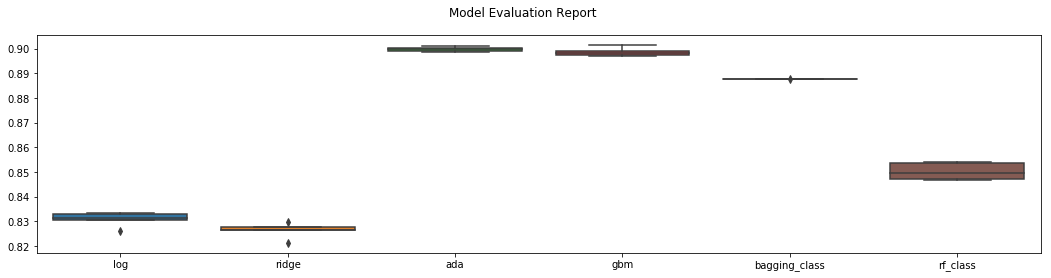

In [25]:
visualize_results(model_results, models_tested)

Adaboost, Gradient Boosted Machine and the Bagging Classifier (unsurprisingly) show better results as they are different variations of ensembles that employ resampling strategies and thus tend to do well with imbalanced classes such as in this case. Next, we will analyze approximation and estimation errors, confusion matrices, and try to pick one model to explore further refinement options such as feature engineering.

Notice we haven't conducted a fully exhaustive hyperparameter search yet so these results are not final, however they give us a good idea for what could have promising results. Furthermore, we will have the option to later search hyperparameters that yield better recall or precision rather than using accuracy as done so far.

In [26]:
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ClassificationReport, PrecisionRecallCurve, ConfusionMatrix

In [27]:
cv = StratifiedKFold(5)
sizes = np.linspace(0.3, 1.0, 10)

In [28]:
#run this just once:
df_eval = df.copy()
y = df_eval.y
y = [1 if i == 'yes' else 0 for i in df_eval.y]
df_eval.drop('y', axis=1, inplace=True)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df_eval, y, test_size=0.2, random_state = 1)

Recreating the three classifiers with their best hyperparameters

In [30]:
best_ada = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=50, random_state=1)

In [31]:
pipe_ada = processing_pipeline(numeric_features, categorical_features, binary_features, label_binary, best_ada)

In [32]:
best_gbm = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=1,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [33]:
pipe_gbm = processing_pipeline(numeric_features, categorical_features, binary_features, label_binary, best_gbm)

In [34]:
best_bg = BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1,
         n_estimators=7, n_jobs=None, oob_score=False, random_state=1,
         verbose=0, warm_start=False)

In [35]:
pipe_bg = processing_pipeline(numeric_features, categorical_features, binary_features, label_binary, best_bg)

Visualizing Model Results

/Applications/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  


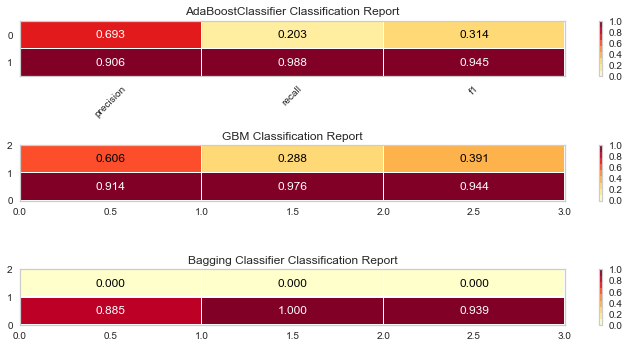

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

In [36]:
fig, axes = plt.subplots(3,1,figsize=(10,5))

cr_ada = ClassificationReport(pipe_ada, ax=axes[0], classes=['1', '0'])
cr_ada.fit(X_train, y_train)
cr_ada.score(X_test, y_test)

cr_gbm = ClassificationReport(pipe_gbm, ax=axes[1], classes=['1', '0'])
cr_gbm.fit(X_train, y_train)
cr_gbm.score(X_test, y_test)

cr_bg = ClassificationReport(pipe_bg, ax=axes[2], classes=['1', '0'])
cr_bg.fit(X_train, y_train)
cr_bg.score(X_test, y_test)

axes[1].set(title='GBM Classification Report')
axes[2].set(title='Bagging Classifier Classification Report')

cr_ada.poof()
cr_gbm.poof()
cr_bg.poof()

Learning curves are showing some variance for Ridge Classifier. Let's look at RandomForestClassifier next

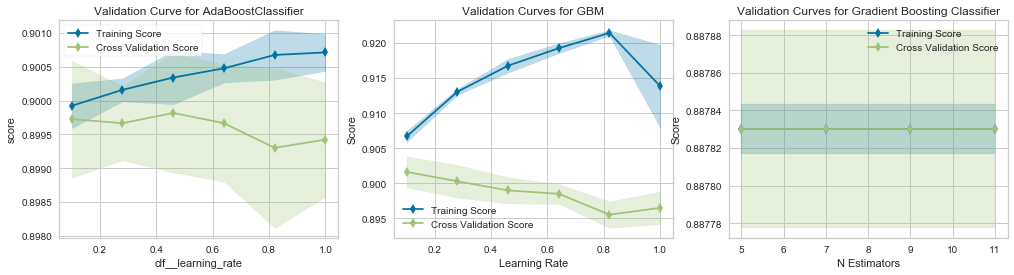

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17,4))

viz_vc_ada = ValidationCurve(
    pipe_ada, param_name="clf__learning_rate",
    param_range=np.linspace(0.1,1, 6), cv=cv, scoring="accuracy", ax=axes[0])

viz_vc_ada.fit(X_train, y_train)

viz_vc_gbm = ValidationCurve(
    pipe_gbm, param_name="clf__learning_rate",
    param_range=np.linspace(0.1,1, 6), cv=cv, scoring="accuracy", ax=axes[1])

viz_vc_gbm.fit(X_train, y_train)

viz_vc_bg = ValidationCurve(
    pipe_bg, param_name="clf__n_estimators",
    param_range=[5,7,9,11], cv=cv, scoring="accuracy", ax=axes[2])

viz_vc_bg.fit(X_train, y_train)

axes[1].set(title='Validation Curves for GBM', xlabel='Learning Rate', ylabel='Score')
axes[2].set(title='Validation Curves for Gradient Boosting Classifier', xlabel='N Estimators', ylabel='Score')
axes[1].legend().set_visible(True)
axes[2].legend().set_visible(True)

viz_vc_ada.poof()
viz_vc_gbm.poof()
viz_vc_bg.poof()

Notice that the above curves are on a very small scale - although they might seem distant from each other, they are actually very close

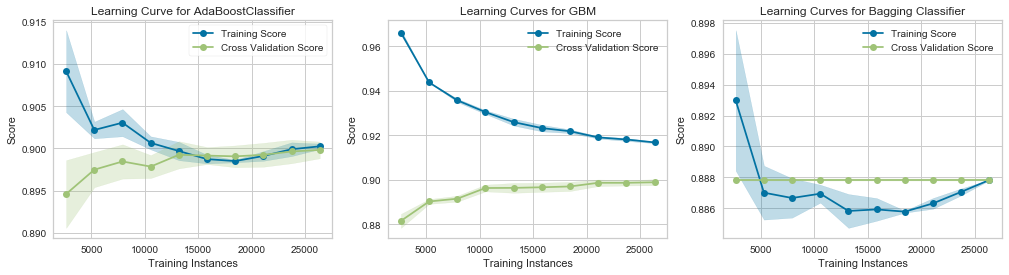

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17,4))

viz_lc_ada = LearningCurve(
    pipe_ada, train_sizes = np.linspace(0.1, 1.0, 10), cv=cv, ax=axes[0]
)
# Fit and poof the visualizer
viz_lc_ada.fit(X_train, y_train)

viz_lc_gbm = LearningCurve(
    pipe_gbm, train_sizes = np.linspace(0.1, 1.0, 10), cv=cv, ax=axes[1]
)
# Fit and poof the visualizer
viz_lc_gbm.fit(X_train, y_train)

viz_lc_bg = LearningCurve(
    pipe_bg, train_sizes = np.linspace(0.1, 1.0, 10), cv=cv, ax=axes[2]
)
# Fit and poof the visualizer
viz_lc_bg.fit(X_train, y_train)

axes[1].set(title='Learning Curves for GBM', xlabel='Training Instances', ylabel='Score')
axes[2].set(title='Learning Curves for Bagging Classifier', xlabel='Training Instances', ylabel='Score')
axes[1].legend().set_visible(True)
axes[2].legend().set_visible(True)

viz_lc_ada.poof()
viz_lc_gbm.poof()
viz_lc_bg.poof()

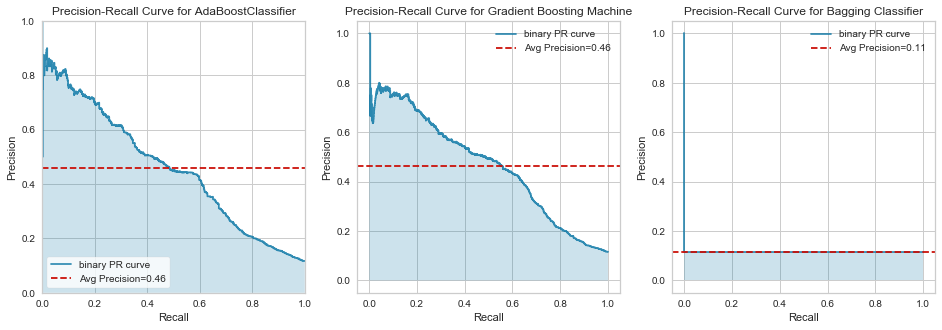

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(16,5))

viz_pc_ada = PrecisionRecallCurve(pipe_ada, ax=axes[0])
viz_pc_ada.fit(X_train, y_train)
viz_pc_ada.score(X_test, y_test)

viz_pc_gbm = PrecisionRecallCurve(pipe_gbm, ax=axes[1])
viz_pc_gbm.fit(X_train, y_train)
viz_pc_gbm.score(X_test, y_test)

viz_pc_bg = PrecisionRecallCurve(pipe_bg, ax=axes[2])
viz_pc_bg.fit(X_train, y_train)
viz_pc_bg.score(X_test, y_test)

axes[1].set(title='Precision-Recall Curve for Gradient Boosting Machine', xlabel='Recall', ylabel='Precision')
axes[2].set(title='Precision-Recall Curve for Bagging Classifier', xlabel='Recall', ylabel='Precision')
axes[1].legend().set_visible(True)
axes[2].legend().set_visible(True)

viz_pc_ada.poof()
viz_pc_gbm.poof()
viz_pc_bg.poof()

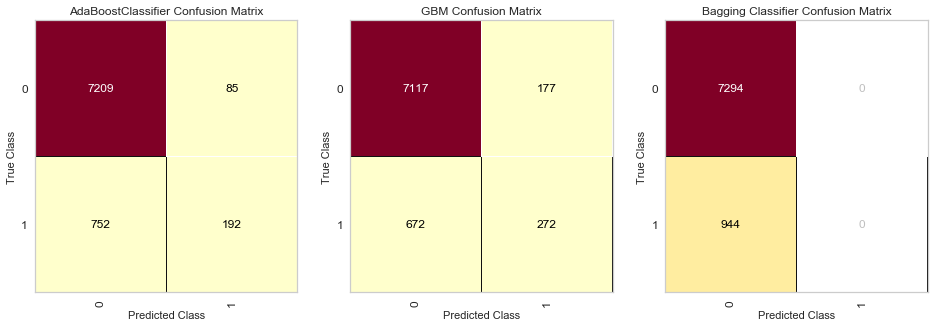

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(16,5))

cm_ada = ConfusionMatrix(pipe_ada, classes=[0,1], ax=axes[0])
cm_ada.fit(X_train, y_train)
cm_ada.score(X_test, y_test)

cm_gbm = ConfusionMatrix(pipe_gbm, classes=[0,1], ax=axes[1])
cm_gbm.fit(X_train, y_train)
cm_gbm.score(X_test, y_test)

cm_bg = ConfusionMatrix(pipe_bg, classes=[0,1], ax=axes[2])
cm_bg.fit(X_train, y_train)
cm_bg.score(X_test, y_test)

axes[1].set(title='GBM Confusion Matrix', xlabel='Predicted Class', ylabel='True Class')
axes[2].set(title='Bagging Classifier Confusion Matrix', xlabel='Predicted Class', ylabel='True Class')

cm_ada.poof()
cm_gbm.poof()
cm_bg.poof()

The Gradient Boosted Classifier is showing great results. Let's try to improve them with new features. **Notice that the features chosen for this dataset were already evaluated and selected from a wider domain by the original researchers: https://archive.ics.uci.edu/ml/datasets/bank+marketing so our efforts in this domain will have to be somewhat limited**

Feature Engineering

In [41]:
#Current feature importances for the GBM model:
pipe_gbm.named_steps['clf'].feature_importances_

array([4.81788546e-02, 1.80017225e-02, 1.81802751e-02, 1.24049211e-02,
       1.82597664e-03, 1.21812088e-02, 5.74373898e-02, 9.73007005e-02,
       4.72332142e-01, 2.30793405e-03, 1.24254820e-03, 1.22521426e-02,
       0.00000000e+00, 1.78915187e-03, 1.59560902e-02, 4.40154203e-03,
       8.06228162e-02, 7.39374326e-04, 7.61825355e-04, 4.33506376e-04,
       5.04993679e-03, 2.06725744e-03, 2.53183292e-03, 2.10559059e-03,
       2.68864741e-03, 7.44662019e-03, 4.81564580e-04, 2.85392951e-03,
       6.60827720e-04, 6.39973268e-04, 1.31352456e-03, 1.39459728e-03,
       3.94783263e-03, 1.63166571e-03, 1.10143866e-04, 4.40436801e-03,
       6.16265645e-03, 5.21331866e-03, 6.79302396e-03, 0.00000000e+00,
       2.00628258e-03, 2.74432955e-03, 1.38691667e-03, 1.56521728e-03,
       6.19225277e-04, 1.19529267e-03, 0.00000000e+00, 6.45101618e-04,
       1.00101609e-03, 1.27334630e-03, 0.00000000e+00, 1.48743916e-02,
       4.11929682e-04, 5.32270191e-03, 3.08709773e-03, 3.30357329e-03,
      

Currently in Sklearn there is no way to use the get_feature_names() function on a Pipeline object. We will create some new features and include a feature elimination step in our pipeline object to eliminate unnecessary features. 

Step 1: we start by binning some of the numeric features. For a visualization of these please visit notebook "feat_eng_tests" located in the same folder.

In [125]:
#Creating some new categorical features with binning:
df['age_bin'] = pd.cut(df['age'], 4, labels = [0,1,2,3])
df['previous_bin'] = pd.cut(df['previous'], 4, labels = [0,1,2,3])
df['campaign_bin'] = pd.cut(df['campaign'], 4, labels = [0,1,2,3])
df['pdays_bin'] = pd.cut(df['pdays'], 4, labels = [0,1,2,3])

Creating some flags reflecting whther if the customer is a new lead, was previously contacted as part of the same campaign, or an old prospect i.e. someone who was contacted in a previous campaign (for a visualization please visit "feat_eng_tests"

In [126]:
df['new_lead'] = np.where((df.previous ==0)&(df.campaign==1),1,0)
#Simple check
#len(df[df['new_lead']==1])

In [127]:
df['new_prospect'] = np.where((df.previous ==0)&(df.campaign>1),1,0)
#Simple check
#len(df[df['new_prospect']==1])

In [128]:
df['old_prospect'] = np.where((df.previous > 0),1,0)
#Simple check
#len(df[df['old_prospect']==1])

Step 2: understand what currently are the features most correlated with y

In [129]:
df = pd.get_dummies(df, columns = ['age_bin', 'previous_bin', 'campaign_bin', 'pdays_bin', 'contact'], drop_first=True)

In [130]:
#It looks like two of the new one hot encoded features contain only zeros. We remove them
set(df.columns) - set(list(df.loc[:, (df != 0).any(axis=0)]))

{'pdays_bin_1', 'pdays_bin_2'}

In [131]:
df.drop(columns=list(set(df.columns) - set(list(df.loc[:, (df != 0).any(axis=0)]))), inplace=True)

In [132]:
#preparing dataframe for correlation analysis
df_corr = df.copy()
df_corr.reset_index(inplace=True)
df_corr.drop('Date', axis=1, inplace=True)
df_corr.drop(columns=numeric_features, inplace=True)
df_corr['y'] = [1 if i == 'yes' else 0 for i in df_corr['y']]

In [133]:
def check_all(pdseries):
    if all(x == pdseries[0] for x in pdseries):
        print("All elements in list are equal")
        print('Feature name: ', pdseries.name)
    else:
        pass

In [134]:
#Checking for any features that have the same value - this would cause an error when calculating correlations.
df_corr.apply(lambda x: check_all(x))

y                                            None
is_holiday                                   None
biz_payday                                   None
govt_payday                                  None
poutcome_nonexistent                         None
poutcome_success                             None
job_blue-collar                              None
job_entrepreneur                             None
job_housemaid                                None
job_management                               None
job_retired                                  None
job_self-employed                            None
job_services                                 None
job_student                                  None
job_technician                               None
job_unemployed                               None
job_unknown                                  None
marital_married                              None
marital_single                               None
marital_unknown                              None


In [135]:
from scipy import stats
import math
#Correlation between features and (binary) target var
pbcorr_list = []
for i in df_corr.columns:
    if math.isnan(stats.pointbiserialr(df_corr[i],df_corr['y'])[0]) != True:
        pbcorr_list.append((str(i), stats.pointbiserialr(df_corr[i],df_corr['y'])[0]))

In [136]:
#Keeping features exhibiting stronger correlation with target var: 
list(filter(lambda x: x[1] < -.1, pbcorr_list)) + list(filter(lambda x: x[1] > .10, pbcorr_list)) 

[('poutcome_nonexistent', -0.19350684552056135),
 ('month_last_contact_may', -0.10827118387516642),
 ('month_5', -0.10827118387516642),
 ('new_prospect', -0.10598331942372181),
 ('pdays_bin_3', -0.3248766977898388),
 ('contact_telephone', -0.14477305571200072),
 ('y', 1.0),
 ('poutcome_success', 0.31626938381981556),
 ('month_last_contact_mar', 0.14401401664144514),
 ('month_last_contact_oct', 0.13736593059421323),
 ('month_last_contact_sep', 0.12606735856323756),
 ('year_2009', 0.16103225253516018),
 ('year_2010', 0.2964693010722249),
 ('month_9', 0.12290204938359565),
 ('month_10', 0.13736593059421323),
 ('old_prospect', 0.19350684552056135),
 ('previous_bin_1', 0.18671831636582317)]

Based on the above, we pick some attributes so we can create new feature combinations. The list above could be filtered out with higher or lower correlation threshold and this exercise could be repeated in multiple iterations. A new feature will be created for each tuple in combos.

In [137]:
cols = ['pdays_bin_3', 'previous_bin_1', 'old_prospect', 
        'poutcome_success', 'month_last_contact_mar', 
        'contact_telephone', 'month_5', 'year_2010', 
        'poutcome_nonexistent']

In [138]:
import itertools
combos = []
for r in range(4,len(cols)):
    combos+= [i for i in list(itertools.combinations(cols, r))]

In [139]:
def create_cat_features(df, combos, pred_var, operation):
    
    if operation == 'sum':
    
        for combo in combos:
            df_temp = df[list(combo) + [pred_var]].groupby(list(combo)).sum().reset_index(drop=0)
            combo_name = pred_var +'-'+'-'.join(combo)+'-categorical'
            df_temp.rename(columns = {pred_var:combo_name}, inplace=True)
            df = df.merge(df_temp, how='left', on=list(combo))
    
    elif operation == 'avg':
        
        for combo in combos:
            df_temp = df[list(combo) + [pred_var]].groupby(list(combo)).mean().reset_index(drop=0)
            combo_name = pred_var +'-'+'-'.join(combo)+'-categorical'
            df_temp.rename(columns = {pred_var:combo_name}, inplace=True)
            df = df.merge(df_temp, how='left', on=list(combo))
    
    else:
        print("You have entered the wrong operation")
        print("Please enter sum or avg")
    
    return df

In [140]:
new_df_pdays = create_cat_features(df, combos, 'pdays', 'avg')

In [141]:
new_df_camp = create_cat_features(df, combos, 'campaign', 'avg')

In [142]:
new_df_prev = create_cat_features(df, combos, 'previous', 'avg')

In [143]:
new_df_pdays = new_df_pdays.merge(new_df_camp, left_index=True, right_index=True,how='inner', suffixes=('', '_rightdf'))
new_df_pdays = new_df_pdays.merge(new_df_prev, left_index=True, right_index=True,how='inner', suffixes=('', '_rightdf'))

In [144]:
final_df = new_df_pdays.drop(new_df_pdays.filter(regex="_rightdf").columns, axis=1)

In [145]:
#Checking outputs:

In [146]:
final_df['previous-old_prospect-poutcome_success-month_last_contact_mar-contact_telephone-month_5-year_2010-categorical'].unique()

array([0.        , 1.1       , 1.2       , 1.12139358, 1.27509294,
       1.10526316, 1.        , 1.07482993, 1.05662726, 1.14285714,
       1.03571429, 1.49275362, 1.64179104, 1.36363636, 1.95982143,
       1.7431694 , 1.76086957, 1.59677419, 1.72222222, 2.43283582,
       1.88888889, 1.33333333])

In [147]:
final_df['previous-pdays_bin_3-old_prospect-poutcome_success-month_last_contact_mar-contact_telephone-month_5-year_2010-categorical'].unique()

array([0.        , 1.06542056, 1.2       , 1.08566629, 1.27509294,
       1.05555556, 1.        , 2.        , 2.37254902, 1.07482993,
       1.05009393, 1.14285714, 2.1       , 1.03571429, 2.33333333,
       1.3442623 , 1.64179104, 2.625     , 1.36363636, 1.95982143,
       1.57051282, 1.76086957, 1.41818182, 2.74074074, 1.58695652,
       2.43283582, 1.88888889, 1.33333333, 2.5       , 3.        ])

Next we will modify our pipeline to include a feature selection step and see if the new features help us increase accuracy

In [148]:
#Not needed since we will directly get dummies with the four new attributes
#categorical_features.extend(['age_bin', 'previous_bin', 'campaign_bin', 'pdays_bin'])

In [149]:
numeric_features.extend(list(filter(lambda x: x.endswith('categorical'), final_df.columns)))

In [150]:
binary_features.extend(['new_lead', 'new_prospect', 'old_prospect'])

Next we create a new pipeline to process the dataset with RFECV

In [151]:
def new_pipeline(numeric_features, bin_features, lab_bin_features, 
                 model, X_train, X_test, y_train, y_test):

    #numeric_features and categorical_features must be lists

    numeric_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])

    binary_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('binary', Binarizer())])
    
    #label_binary_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        #('label_binary', OneHotEncoder(sparse=False))])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('bin', binary_transformer, bin_features) 
        #('lab_bin', label_binary_transformer, lab_bin_features) 
    ], 
        #setting remainder to passthrough so features that are not included are not dropped
        remainder='passthrough')
    
    selector = RFECV(estimator = model, step = 40, cv=StratifiedKFold(n_splits=2, random_state=1))

    combined_features = FeatureUnion([('preprocessor', preprocessor),
                                    ('selection', selector)])
    
    X_train_new = combined_features.fit(X_train,y_train).transform(X_train)
    
    pipeline = Pipeline([('features', combined_features), ("model", model)])
    
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    
    
    #cv_metric = cross_val_score(gs, X_train, y_train, cv=cv)

    print("\n---------")
    print("Model Evaluated: ", model)
    print("Test Score: %.3f" % score)

    return X_train_new, combined_features

In [152]:
X_train, X_test, y_train, y_test = split_data(final_df, 'y', 0.2)

In [153]:
best_gb_fs = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=1,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [154]:
X_train_new, combined_features = new_pipeline(numeric_features, binary_features, _, 
                 best_gb_fs, X_train, X_test, y_train, y_test)


---------
Model Evaluated:  GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=1,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Test Score: 0.895


In [155]:
#Try the process above with more and different features and feature selection methods

Once completed, retrain on the whole dataset and selected feature set so the model can be exported

Improvements:
- try voting classifier or any custom ensemble?
- use imbalanced learning library and different sampling techniques with different models and see if it is possible to obtain similar performance
- try using chi square test as a way to view correlation between cat features
- plot classifier comparisons with respect to the most important feature
- insert statistical tests and plot distributions for the new features created with combos and use statistical insights to remove some before feeding them to the new pipeline
- try creating more features with more combos and then add PCA to the new pipeline as a way to reduce dimensionality

The above feature selection seems to NOT have further improved our model. See the feature_selection notebook for more attempts.

NB: for now I am exporting the pipeline prior to feature engineer as it didn't yield any improvements. I will be expanding on my feature engineering work later and hopefully export an improved model and dataset

In [42]:
#reloading original df with transformations used so I can fit and export the best pipeline found so far
#NB this will need to be changed once feature eng is over.
df = pd.read_pickle('data/data_ready.pickle')

df.drop(columns=['duration', 'day'], axis=1, inplace=True)

df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

In [43]:
#fit pipe_gbm before exporting it 

In [44]:
#not just of type numeric, but actual numeric on a scale - excludes binary and ordinal categorical attributes
#the below attributes will be scaled in the Pipeline
numeric_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
                   'cons.conf.idx', 'euribor3m', 'nr.employed', 'month_total_days']

In [45]:
binary_features = ['biz_payday', 'govt_payday', 'is_holiday']

In [46]:
#outcome is y,n,unknown
categorical_features = ['poutcome', 'job', 'marital', 'education', 'default', 'housing', 'loan', 
                       'month_last_contact', 'day_of_week_last_contact', 'holiday_name', 'weekday', 
                       'year', 'month']

In [47]:
label_binary = ['contact']

In [48]:
pipe_gbm = processing_pipeline(numeric_features, categorical_features, binary_features, label_binary, best_gbm)

In [49]:
X_train, X_test, y_train, y_test = split_data(df, 'y', 0.2)

In [50]:
pipe_gbm.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['age', 'campaign', 'pdays...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [51]:
#save the model here so it can be used by other notebooks
pickle.dump(pipe_gbm, open('finalized_model.sav', 'wb'))

In [52]:
X_train.to_csv('data/X_train.csv')
X_test.to_csv('data/X_test.csv')
y_train.to_csv('data/y_train.csv')
y_test.to_csv('data/y_test.csv')

/Applications/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


In [181]:
#%store X_train
#%store X_test
#%store y_train
#%store y_test
#%store final_df

Stored 'X_train' (DataFrame)
Stored 'X_test' (DataFrame)
Stored 'y_train' (Series)
Stored 'y_test' (Series)
Stored 'final_df' (DataFrame)
